In [78]:
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import scipy as sci
from sklearn.cluster import KMeans


# Utils

In [3]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """  
    distance=squareform(pdist(X, 'euclidean'))
    print(np.mean(distance))
    weights=np.exp(-distance**2/(2*sigma*sigma))
    np.fill_diagonal(weights,0)
    plt.hist(weights.reshape(weights.shape[0]**2 ,1),bins=100)
    plt.title("distance treshold")
    plt.show()
    adjacency=weights
    adjacency[adjacency<epsilon]=0
    a=np.ones_like(adjacency)
    return adjacency

# Prepare data

In [126]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

In [127]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

# keep only summury information of each county
df_migrations = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration")]

# create the combined fips county number 
df_migrations['statefips_str'] = df_migrations['y2_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str'] = df_migrations['y2_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips'] = df_migrations['statefips_str'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str']

# drop useless information 
df_migrations = df_migrations.drop(columns=["y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str"])

# seperate each possible migration into three dataframe 
df_migration_total = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US and Foreign")]
df_migrations['y1_countyname'] = df_migrations['y1_countyname'].apply(lambda x : x if x.find("County Total Migration-US and Foreign") == -1 else "County Total Migration Both")
df_migration_us = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US")]
df_migration_for = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-Foreign")]

# drop the name of the column 
df_migration_total = df_migration_total.drop(columns=["y1_countyname"])
df_migration_us = df_migration_us.drop(columns=["y1_countyname"])
df_migration_for = df_migration_for.drop(columns=["y1_countyname"])

# remove nodes where data is undefined undefined data by zero
df_migration_total = df_migration_total[df_migration_total['n1'] != -1]
df_migration_us = df_migration_us[df_migration_us['n1'] != -1]
df_migration_for = df_migration_for[df_migration_for['n1'] != -1]

# convert combined fips to int64
df_migration_total['combined_fips'] = df_migration_total['combined_fips'].astype('int64')
df_migration_us['combined_fips'] = df_migration_us['combined_fips'].astype('int64')
df_migration_for['combined_fips'] = df_migration_for['combined_fips'].astype('int64')

In [128]:
df_presidential_result = pd.read_csv("./NTDS_Data/2016_US_County_Level_Presidential_Results.csv" )
df_presidential_result = df_presidential_result.drop(columns=["Unnamed: 0","votes_dem", "votes_gop", "total_votes", "diff", "per_point_diff", "state_abbr", "county_name"])

In [129]:
# merge the two dataset and drop useless column, add a new column winner 
df_merged_total = pd.merge(df_migration_total, df_presidential_result, on="combined_fips", how='inner')
df_merged_us = pd.merge(df_migration_us, df_presidential_result, on="combined_fips", how='inner')
df_merged_for = pd.merge(df_migration_for, df_presidential_result, on="combined_fips", how='inner')
df_merged_total['difference'] = df_merged_total['per_dem'] - df_merged_total['per_gop']
df_merged_us['difference'] = df_merged_us['per_dem'] - df_merged_total['per_gop']
df_merged_for['difference'] = df_merged_for['per_dem'] - df_merged_total['per_gop']
df_merged_total['winner'] = df_merged_total['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_us['winner'] = df_merged_us['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_for['winner'] = df_merged_for['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_total = df_merged_total.drop(columns=['difference'])
df_merged_us = df_merged_us.drop(columns=['difference'])
df_merged_for = df_merged_for.drop(columns=['difference'])

# Compute Adjacency matrix

0.5284353963018223


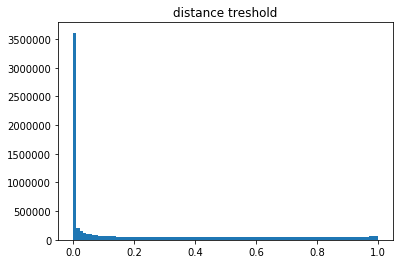

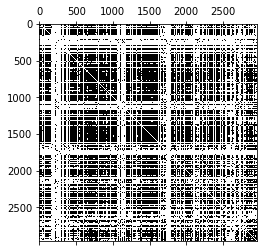

In [8]:
X_total = df_merged_total.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_total = df_merged_total.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_total['agi'] = (X_total['agi'] - X_total['agi'].mean()) / X_total['agi'].std()
X_total['prop_ret/exempt'] = X_total['n1'] / X_total['n2']
X_total = X_total.drop(columns=['n1', 'n2'])
adjacency_RGB_total = epsilon_similarity_graph(X_total, sigma=0.5284353963018223*0.1, epsilon=0.2)
plt.spy(adjacency_RGB_total)
plt.show()

# signal => gft => lp => igft => adjacency and neighbour => threshold

In [85]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    Degrees=np.diag(np.sum(adjacency,1))
    #print(  (np.sum(adjacency,1) == 0).any()   )
    if normalize==False:
        L=Degrees-adjacency
    if normalize==True:
        D_norm=np.diag(np.sum(adjacency,1)**(-1/2))
        L=D_norm@(Degrees-adjacency)@D_norm
    return L

def spectral_decomposition(laplacian: np.ndarray):
    lamb, U=sci.linalg.eigh(laplacian)
    sorted_idx = np.argsort(lamb)
    lamb = lamb[sorted_idx]
    U=U[:,sorted_idx]
    return lamb,U

In [ ]:
# ERROR => DIVISION BY ZERO
laplacian_norm = compute_laplacian(adjacency_RGB_total, normalize=True)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

### Division by zero in normalized lapacien computation

- some nodes do not have any connection in the graph => create new adjacency matrix A by deleting these nodes

In [293]:
A = adjacency_RGB_total.copy()

rows_to_be_deleted = np.where(np.sum(adjacency_RGB_total,1) == 0)
print("Number nodes to be deleted:",len(rows_to_be_deleted[0]))
A = np.delete(A, rows_to_be_deleted,0)
A = np.delete(A, rows_to_be_deleted,1)
print("Original adjacenye shape:",adjacency_RGB_total.shape)
print("Now new shape is:",A.shape)
print("symmetric check:",(A == A.T).all())

Number nodes to be deleted: 24
Original adjacenye shape: (2963, 2963)
Now new shape is: (2939, 2939)
symmetric check: True


In [294]:
laplacian = compute_laplacian(A, normalize=True)
lamb, U = spectral_decomposition(laplacian)

In [295]:
lamb  # fine

array([-6.80059625e-16, -6.66575771e-16, -6.56911594e-16, ...,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00])

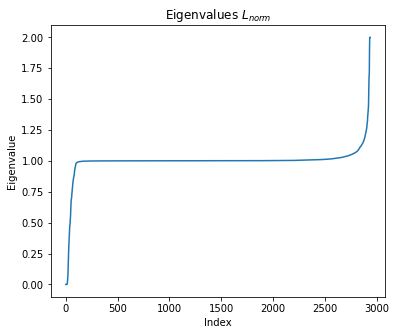

In [296]:
plt.figure(figsize=(6,5))
plt.plot(lamb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [297]:
def compute_number_connected_components(lamb: np.array, threshold: float):
    
    n_components=lamb[lamb <= threshold].shape[0] 
    
    return n_components

In [298]:
print(compute_number_connected_components(lamb, threshold=1e-04)) 

12


# Corresponding nodes should also be deleted in "winner"

In [299]:
print(rows_to_be_deleted) # for adjacency matrix
print("length:",len(rows_to_be_deleted[0]))

(array([  74,  157,  163,  175,  189,  192,  194,  197,  199,  230,  295,
        334,  411,  573, 1124, 1649, 1731, 1741, 1760, 2430, 2444, 2488,
       2685, 2790]),)
length: 24


In [300]:
x = df_merged_total["winner"]
x = np.delete(np.array(x), rows_to_be_deleted,0) # delete for "winner"
print(len(x))

2939


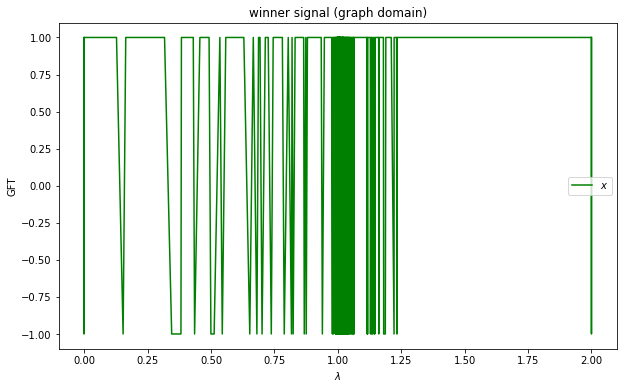

In [301]:
plt.figure(figsize=(10, 6))
plt.plot(lamb, x, 'g-')   # lamb as y ---?
plt.title("winner signal (graph domain)")
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$x$'])

In [302]:
def GFT(signal, U):
    # Your code here
    print(len(signal))
    return U.T @ signal

def iGFT(fourier_coefficients, U):
    # Your code here
    return U @ fourier_coefficients

2939


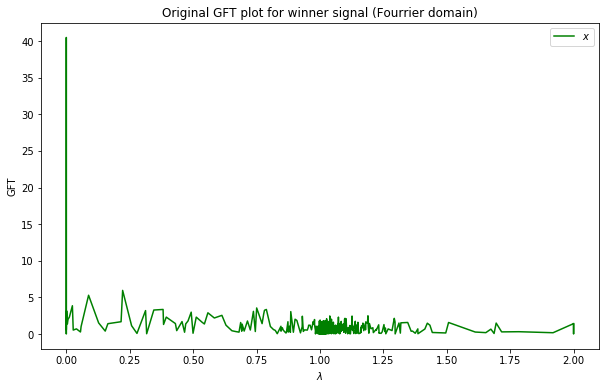

In [303]:
plt.figure(figsize=(10, 6))
plt.plot(lamb, np.abs(GFT(x,U)), 'g-')
plt.title("Original GFT plot for winner signal (Fourrier domain)")
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$x$'])

# Randomly choose some points for prediction use

In [263]:
test_idx = np.random.choice(np.arange(len(x)),int(len(x)*0.2),replace = False)
test_idx

array([ 508, 2175,  788,  321,   14, 2060, 2124,  193,  813,  816,  225,
       1709,  330, 2400, 1700, 2813, 2329, 2874, 1085, 2597, 1061, 2143,
        456, 1689, 1957, 1852, 1478, 1760, 1139, 2320, 1330, 1898, 1243,
       2283,  636, 2707, 2365, 1290, 1787,   71,  328,  883, 2629, 1413,
       1308, 2287, 2323,   65, 1008,  229, 1214, 1346,  756, 2247,  270,
        192, 1949, 2137, 2916, 2317, 1606,  138,  422, 2605, 1316, 2816,
       1781, 1873, 1258,  760, 1088, 2697, 1748, 1938, 2431, 2529, 2859,
       2620, 2404, 1891, 1294,  649, 2139, 1148,  317, 1933, 2337,  430,
        363,  255,   86, 2080,  661,  790, 2511,  552,  581, 1404, 1099,
         24, 2093,  801, 1329, 1391, 2545,  479, 2062, 2676, 1840,  495,
        731, 2547, 2504,  105, 1766, 1376, 2773, 1326, 1939,  663, 1639,
       1033, 2201, 2684, 1557, 2809,   43, 2363, 1820, 2464, 2721,   99,
       1381,  186, 2031,  793,  349,  335, 1467, 1667,   77, 1262, 2744,
       1877, 1707,  124,  637,  805, 1034,  950, 16

In [304]:
# masking some winner
x[test_idx]=0

2939


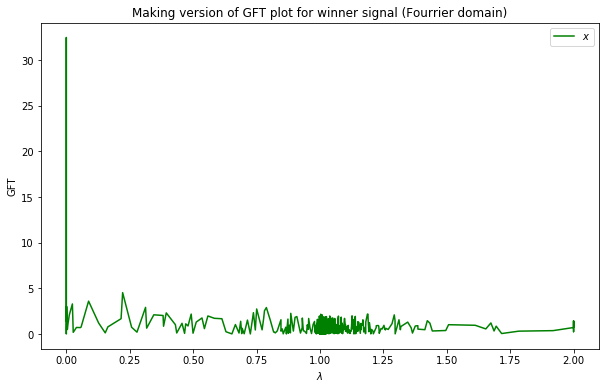

In [305]:
plt.figure(figsize=(10, 6))
plt.plot(lamb, np.abs(GFT(x,U)), 'g-')  
plt.title("Making version of GFT plot for winner signal (Fourrier domain)")
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$x$'])

# Create filter for later use

In [306]:
n_nodes = A.shape[0]
ideal_lp = np.ones((n_nodes,)) 
ideal_lp[lamb >= 0.1] = 0   # to tune

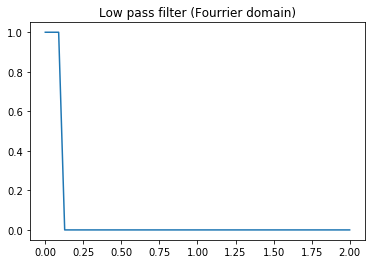

In [307]:
plt.title("Low pass filter (Fourrier domain)")
plt.plot(lamb, ideal_lp, '-', label='LP')

# Filter the signal

In [308]:
def ideal_graph_filter(x, spectral_response, U):
    """Return a filtered signal."""
    # Your code here
    # spectral_response is in the fourier domain
    # x is in the graph domain
    # need to converge x to the fourier domain 
    # finally convert all back to the graph domain
    return iGFT(GFT(x,U) * spectral_response, U)

2939


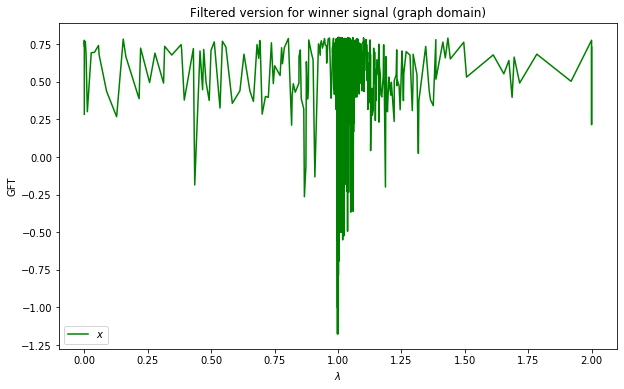

In [309]:
x_lp = ideal_graph_filter(x,ideal_lp,U)

plt.figure(figsize=(10, 6))
plt.plot(lamb, x_lp, 'g-')
plt.title("Filtered version for winner signal (graph domain)")
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$x$'])

# Thresholding by 0

- Try to find connected neigbhours using non-zero entries in the adjacency matrix 

--- right ?

In [315]:
pred = []
for i in test_idx:
    l = np.where(A[i] !=0)[0]  # searching neigbhours
    tmp = 0
    for j in l:
        tmp += x_lp[j]
    pred.append(tmp/len(l))   # compute mean

In [329]:
pred_thres = np.array(pred)
(pred_thres==0).any() # check ok

False

In [320]:
# thresholding
pred_thres [pred_thres >0 ] = 1
pred_thres [pred_thres <0 ] = -1

In [330]:
# ground truth
truth = (df_merged_total["winner"][test_idx]).values

In [331]:
wrong_pred = []
for i in range(len(pred_thres)):
    if(pred[i] != truth[i]):
        wrong_pred.append(i)
len(wrong_pred)

104

In [332]:
accurary = 1 - len(wrong_pred)/len(test_idx)
accurary 

0.8228279386712095

# => Result of prediction of winner: accuracy 0.8228279386712095 
Randomly maksing 20% of the target label

# Problem:
- algo: why low pass; [0,1,-1,1,0] => iGFT(GFT*lp) =>  [_,?,?,?,_]
- plot with lamb ?
- good graph ?  => `agi` and `exemplt` can predict the winner at 82%
- satisfactory result ?

# To ignore

In [ ]:
x_lp [x_lp >0 ] = 1
x_lp [x_lp <0 ] = -1

pred = x_lp[test_idx]

truth = (df_merged_total["winner"][test_idx]).values# ground truth

np.sqrt(sum((pred-truth)**2))  # rsme

wrong_pred = []
for i in range(len(pred)):
    if(pred[i] != truth[i]):
        wrong_pred.append(i)
len(wrong_pred)

accurary = 1- len(wrong_pred)/len(test_idx)
accurary #accurary = 1- len(wrong_pred)/len(test_idx)
accurary 